# **Regime Aware Drawdown Risk State Predictor**

> *Given today’s market behavior and its regime, what is the probability that the market will be in a high drawdown risk state tomorrow?*

**Objective**: Predict next-day drawdown risk using regime-aware features.
- Using **returns, volatility, & regime labels**
- Predict whether the market will enter a **high drawdown risk** state the next day.

### **Why this matters..?**
- Same volatility means different risk in different regimes
- A **−1%** move in a calm regime **≠** **−1%** in a crisis regime

# **Imports & Data Loading**

In [1356]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import yfinance as yf


In [1357]:
# S&P 500 data
df = yf.download("^GSPC", start="2005-01-01", end="2024-01-01")

df.head(3)


/tmp/ipython-input-1136220247.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("^GSPC", start="2005-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2005-01-03,1202.079956,1217.800049,1200.319946,1211.920044,1510800000
2005-01-04,1188.050049,1205.839966,1185.390015,1202.079956,1721000000
2005-01-05,1183.739990,1192.729980,1183.719971,1188.050049,1738900000


In [1358]:
df.columns

MultiIndex([( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])

In [1359]:
# Fix yfinance MultiIndex columns
df.columns = df.columns.get_level_values(0)

df.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2005-01-03,1202.079956,1217.800049,1200.319946,1211.920044,1510800000
2005-01-04,1188.050049,1205.839966,1185.390015,1202.079956,1721000000
2005-01-05,1183.739990,1192.729980,1183.719971,1188.050049,1738900000
2005-01-06,1187.890015,1191.630005,1183.270020,1183.739990,1569100000
2005-01-07,1186.189941,1192.199951,1182.160034,1187.890015,1477900000


In [1360]:
df.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [1361]:
df.shape

(4781, 5)

In [1362]:
df.columns.name = None

In [1363]:
df = df[['Close']]
df.dropna(inplace=True)

In [1364]:
df.shape

(4781, 1)

# **Feature Engineering**

In [1365]:
# Daily Returns: How much did the market move today?

df['return'] = df['Close'].pct_change()


In [1366]:
# Volatility (Risk): How violently prices move (risk intensity)

df['volatility'] = df['return'].rolling(20).std()

In [1367]:
# Trend Strength (MA Slope):Is the market trending up or down?

df['ma'] = df['Close'].rolling(20).mean()
df['trend_strength'] = df['ma'].pct_change()


In [1368]:
# Momentum: Short-term directional pressure

df['momentum'] = df['return'].rolling(5).sum()

In [1369]:
# Drawdown: How deep are losses from the peak?

rolling_max = df['Close'].cummax()
df['drawdown'] = (df['Close'] - rolling_max) / rolling_max


In [1370]:
df.dropna(inplace=True)

In [1371]:
df.shape

(4761, 7)

In [1372]:
df.sample()

,Close,return,volatility,ma,trend_strength,momentum,drawdown
Date,,,,,,,
2020-10-12,3534.219971,0.016416,0.01239,3363.413,0.002245,0.036643,-0.013019


# **Data Visualization**

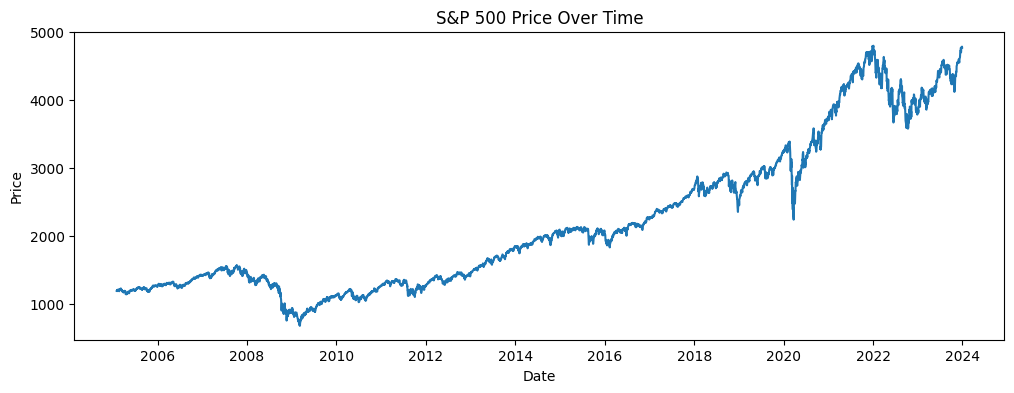

In [1373]:
# Price Trend: Market Overview

plt.figure(figsize=(12,4))
plt.plot(df['Close'])
plt.title("S&P 500 Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

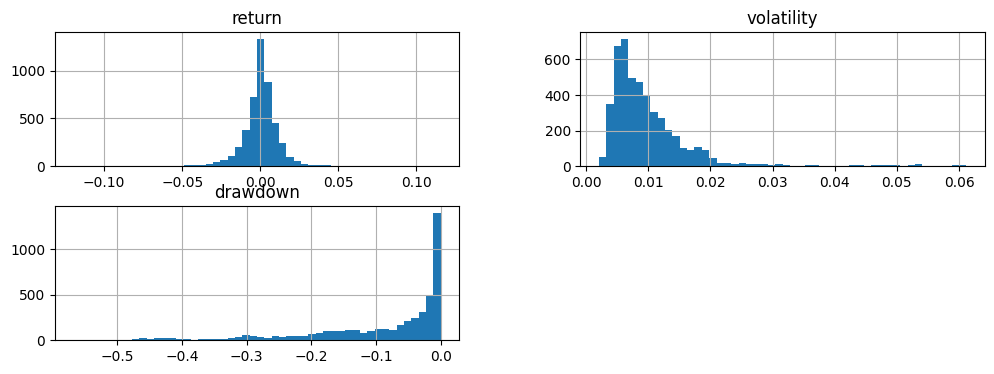

In [1374]:
# Feature Visualization (Understanding the Data)

df[['return', 'volatility', 'drawdown']].hist(
    figsize=(12,4), bins=50
)
plt.show()

# **Regime Based**

In [1375]:
regimes = pd.read_csv("outputs/regimes.csv", index_col=0)


In [1376]:
regimes.sample()

,return,volatility,drawdown,regime
Date,,,,
2024-09-25,-0.001861,0.008131,-0.001861,1


In [1377]:
regimes.columns

Index(['return', 'volatility', 'drawdown', 'regime'], dtype='object')

In [1378]:
df.columns

Index(['Close', 'return', 'volatility', 'ma', 'trend_strength', 'momentum',
       'drawdown'],
      dtype='object')

In [1379]:
df = df.reset_index()

In [1380]:
regimes = regimes.reset_index()

In [1381]:
print(df['Date'].dtype)
print(regimes['Date'].dtype)

datetime64[ns]
object


# **Merge Data**

In [1382]:
df['Date'] = pd.to_datetime(df['Date'])
regimes['Date'] = pd.to_datetime(regimes['Date'])

In [1383]:
print(df['Date'].dtype)
print(regimes['Date'].dtype)

datetime64[ns]
datetime64[ns]


In [1384]:
df = df.merge(
    regimes[['Date', 'regime']],
    on='Date',
    how='inner'
)


In [1385]:
# REGIME MAPPING

regime_map = {
    0: "Crisis",
    1: "Calm",
    2: "Volatile"
}

df['regime'] = df['regime'].map(regime_map)


In [1386]:
df[['Date', 'regime']].sample(3)

,Date,regime
3170,2017-09-05,Calm
3206,2017-10-25,Calm
400,2006-09-01,Calm


In [1387]:
df['regime'].value_counts()

,count
regime,
Calm,3310
Crisis,1023
Volatile,428


# **Target: Drawdown Risk**

> High drawdown risk = the market being in a **stressed drawdown state tomorrow** (relative to its rolling peak).

In [1388]:
df['future_drawdown'] = df['drawdown'].shift(-1)

df['drawdown_risk'] = (df['future_drawdown'] < -0.02).astype(int)

# A −2% drawdown threshold is used to capture early stress rather than extreme crisis events.

In [1389]:
df.columns

Index(['Date', 'Close', 'return', 'volatility', 'ma', 'trend_strength',
       'momentum', 'drawdown', 'regime', 'future_drawdown', 'drawdown_risk'],
      dtype='object')

In [1390]:
df.sample(2)

,Date,Close,return,volatility,ma,trend_strength,momentum,drawdown,regime,future_drawdown,drawdown_risk
4728,2023-11-13,4411.549805,-0.000836,0.009979,4283.596484,0.000443,0.010542,-0.080268,Calm,-0.062724,1
60,2005-04-28,1143.219971,-0.011380,0.009270,1164.806494,-0.001602,-0.014356,-0.066995,Volatile,-0.055872,1


### **Next-day drawdown risk prediction (binary classification)**

- 1 → High risk tomorrow (≥2% drawdown)
- 0 → Normal conditions
- Binary & Intuitive: Risk-focused

In [1391]:
features = [
    'regime',
    'volatility',
    'trend_strength',
    'momentum'
]

x = df[features]
y = df['drawdown_risk']

In [1392]:
x.isna().sum()


,0
regime,0
volatility,0
trend_strength,0
momentum,0


In [1393]:
x.dropna()
x.shape

(4761, 4)

- **regime** → Market environment (calm / - volatile / crisis)
- **volatility** → Current risk intensity
- **trend_strength** → Is the market trending or weakening?
- **momentum** → Short-term directional pressure

**Condition risk prediction on both current regime and market dynamics**

In [1394]:
df.shape

(4761, 11)

### **Class Balance Check**

In [1395]:
df['drawdown_risk'].value_counts(normalize=True)


,proportion
drawdown_risk,
1,0.623819
0,0.376181


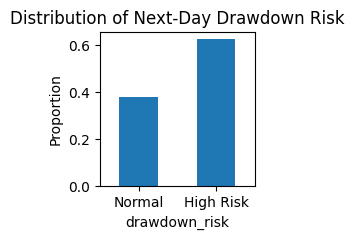

In [1396]:
plt.figure(figsize=(2,2))
df['drawdown_risk'].value_counts(normalize=True).sort_index().plot(kind='bar')
plt.title("Distribution of Next-Day Drawdown Risk")
plt.ylabel("Proportion")
plt.xticks([0,1], ['Normal', 'High Risk'], rotation=0)
plt.show()


- Drawdown risk is **state-persistent**, so **high-risk labels cluster over time**. This is expected for drawdown-based targets.

- Accuracy alone is insufficient, we need **ROC-AUC** is the correct metric.

# **Model Training**

In [1397]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.25,
    shuffle=False
)

In [1398]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

num_features = ['volatility', 'trend_strength', 'momentum']
cat_features = ['regime']

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first'), cat_features)
    ]
)

model = Pipeline([
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=1000))
])


In [1399]:
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)[:, 1]


In [1400]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.62      0.67       445
           1       0.79      0.87      0.83       746

    accuracy                           0.77      1191
   macro avg       0.76      0.74      0.75      1191
weighted avg       0.77      0.77      0.77      1191



In [1401]:
print("ROC AUC:", roc_auc_score(y_test, y_prob))

ROC AUC: 0.8676416543663584


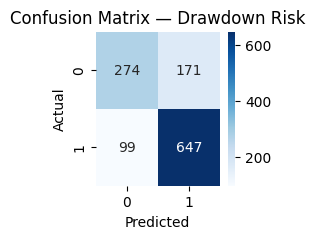

In [1402]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(2,2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Drawdown Risk")
plt.show()


### **ROC-AUC**

> *How well the model ranks positives above negatives, across all thresholds.*

When?
- Classes are **imbalanced**
- Care about **risk ranking, not a fixed cutoff**
- Choose the threshold later
- Want a threshold-free metric

> *If I pick one risky day and one normal day at random, how often does the model rank the risky one higher?*

# **Coefficients**

In [1403]:
feature_names = (
    num_features +
    list(model.named_steps['prep']
         .named_transformers_['cat']
         .get_feature_names_out(cat_features))
)

coefficients = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": model.named_steps['clf'].coef_[0]
}).sort_values(by="Coefficient", ascending=False)

coefficients


,Feature,Coefficient
0,volatility,3.615545
3,regime_Crisis,1.822774
4,regime_Volatile,1.559966
1,trend_strength,-0.087069
2,momentum,-1.019340


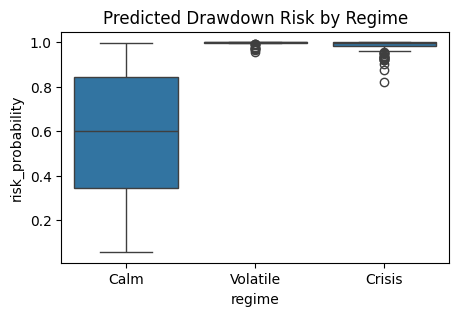

In [1404]:
test_df = df.loc[x_test.index].copy()
test_df['risk_probability'] = y_prob


plt.figure(figsize=(5,3))
sns.boxplot(x='regime', y='risk_probability', data=test_df)
plt.title("Predicted Drawdown Risk by Regime")
plt.show()


In [1405]:
df_test.groupby('regime')['risk_prob'].describe()


,count,mean,std,min,25%,50%,75%,max
regime,,,,,,,,
Calm,888.0,0.580112,0.282037,0.054725,0.343487,0.599883,0.842049,0.998663
Crisis,179.0,0.986003,0.025398,0.822866,0.983159,0.998167,0.999638,1.000000
Volatile,124.0,0.997181,0.007180,0.957112,0.997980,0.999563,0.999964,1.000000


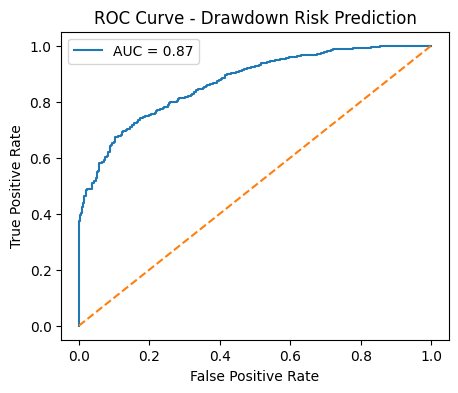

In [1406]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Drawdown Risk Prediction")
plt.legend()
plt.show()


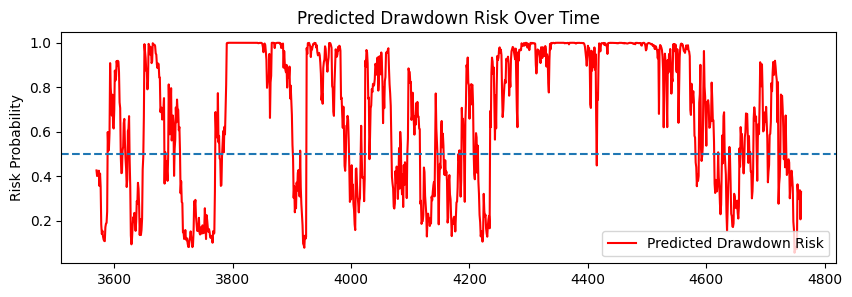

In [1407]:
risk_series = pd.Series(y_prob, index=x_test.index)

plt.figure(figsize=(10,3))
plt.plot(risk_series, label="Predicted Drawdown Risk", color='red')
plt.axhline(0.5, linestyle='--')
plt.title("Predicted Drawdown Risk Over Time")
plt.ylabel("Risk Probability")
plt.legend()
plt.show()


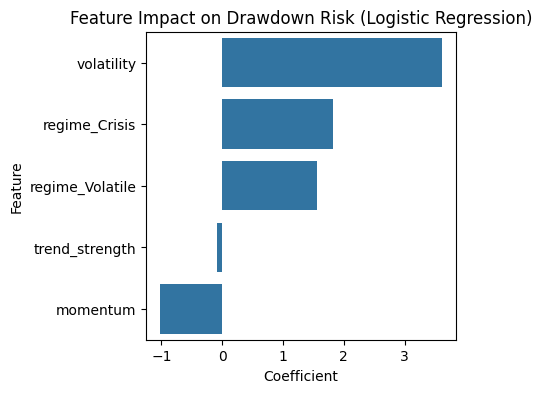

In [1408]:
plt.figure(figsize=(4,4))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=coefficients
)
plt.title("Feature Impact on Drawdown Risk (Logistic Regression)")
plt.show()


Drawdown risk is **driven primarily by volatility**, but the same level of volatility translates into very different risk depending on the market regime, **crisis regimes amplify drawdown risk**, while volatile regimes often reflect turbulent recoveries rather than worsening losses.

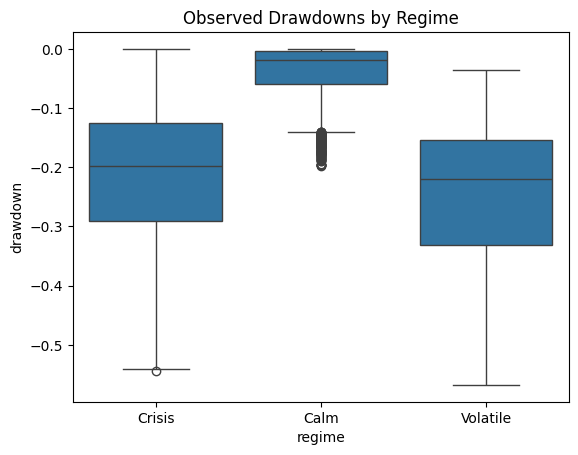

In [1409]:
sns.boxplot(x='regime', y='drawdown', data=df)
plt.title("Observed Drawdowns by Regime")
plt.show()


In [1410]:
x_no_regime = df[
    ['volatility', 'trend_strength', 'momentum']
]

x_train_nr, x_test_nr, y_train, y_test = train_test_split(
    x_no_regime, y,
    test_size=0.25,
    shuffle=False
)

scaler_nr = StandardScaler()
x_train_nr = scaler_nr.fit_transform(x_train_nr)
x_test_nr = scaler_nr.transform(x_test_nr)

model_nr = LogisticRegression(max_iter=1000)
model_nr.fit(x_train_nr, y_train)

roc_nr = roc_auc_score(y_test, model_nr.predict_proba(x_test_nr)[:, 1])


In [1411]:
print("With regime:", roc_auc_score(y_test, y_prob))
print("Without regime:", roc_nr)

With regime: 0.8676416543663584
Without regime: 0.8564026869897883


In [1412]:
import os
os.makedirs("outputs", exist_ok=True)

test_df[['risk_probability', 'drawdown_risk', 'regime']].to_csv(
    "outputs/drawdown_risk.csv"
)
